In [1]:
# PyTorch Imports
import torch
import torch.nn as nn
from torch.nn import Module
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Basic Python Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Module Imports
from Modules.BayesLinear import BayesLinear
from Modules.Loss import BKLLoss
from Modules.BayesHarry import BayesLinear as BayesHarry

import random

random.seed(10)

### Load data
Format for Bayesian NN. Visualisation of the time series.

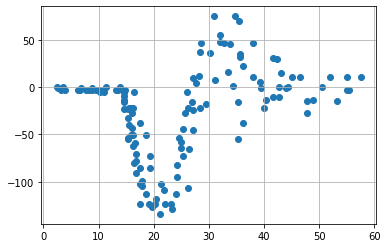

X : torch.Size([133, 1]) Y : torch.Size([133])


In [2]:
# Load data
data = pd.read_csv('Data/motorcycle.csv')

# Plotting the timeseries
plt.figure()
plt.scatter(data['times'], data['accel'])
plt.grid()
plt.show()

# Conversion to float tensors 
x = np.array(data['times'])
y = np.array(data['accel'])

x = torch.unsqueeze(torch.from_numpy(x), dim=1)
y = torch.from_numpy(y)

x = x.float()
y = y.float()

x_np = x.squeeze().numpy()
y_np = y.squeeze().numpy()

print('X :', x.shape, 'Y :', y.shape)

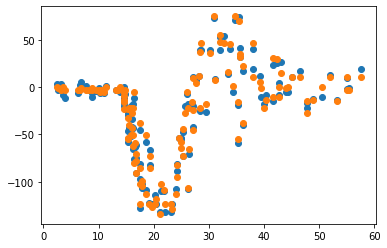

In [3]:
noise = np.random.normal(0, 5, len(y))
ytest = y_np + noise

plt.scatter(x_np, ytest)
plt.scatter(x_np, y_np)

### Model
We consider regression (input and output features = 1) 2 hidden layers. 

In [4]:
class Net(Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden1 = BayesLinear(prior_mu=0, prior_sigma=0.05, in_features=n_feature, out_features=n_hidden, bias=True)   # hidden layer
        self.hidden2 = BayesLinear(prior_mu=0, prior_sigma=0.05, in_features=n_hidden, out_features=n_hidden, bias=True)
        self.predict = BayesLinear(prior_mu=0, prior_sigma=0.05, in_features=n_hidden, out_features=n_output, bias=True)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden1(x))      # activation function for hidden layer
        x = F.relu(self.hidden2(x))
        x = self.predict(x)              # linear output
        return x
    
net = Net(n_feature=1, n_hidden=500, n_output=2)     # define the network
print(net)  # net architecture

Net(
  (hidden1): BayesLinear(prior_mu=0, prior_sigma=0.05, in_features=1, out_features=500, bias=True)
  (hidden2): BayesLinear(prior_mu=0, prior_sigma=0.05, in_features=500, out_features=500, bias=True)
  (predict): BayesLinear(prior_mu=0, prior_sigma=0.05, in_features=500, out_features=2, bias=True)
)


### Training

In [6]:
net = net.float()

optimizer = optim.Adam(net.parameters(),  lr=0.001)

kl_loss = BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01


for t in range(3000):
    
    prediction = net(x)     # input x and predict based on x
    
    kl = kl_loss(net)
    
    distribution = torch.distributions.Normal(prediction[:,0], torch.exp(prediction[:,1]))
    cost = -distribution.log_prob(y).sum() + kl_weight*kl
    
    optimizer.zero_grad()
    cost.float().backward()
    optimizer.step()
    
print('- MSE : %2.2f, KL : %2.2f' % (cost.item(), kl.item()))

ValueError: The parameter loc has invalid values

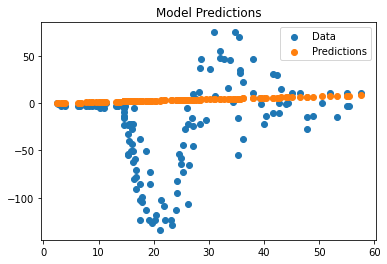

In [7]:
plt.figure()
plt.scatter(x, y, label='Data')
plt.scatter(x, y_pred[:,0], label='Predictions')
plt.title('Model Predictions')
plt.legend()
plt.show()

ValueError: could not broadcast input array from shape (133,2) into shape (133,)

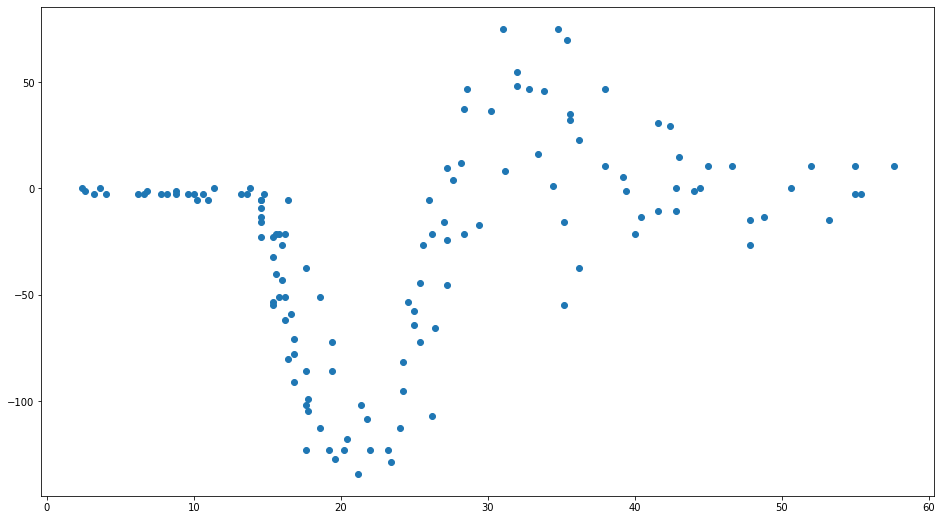

In [8]:
num_predictions = 100
prediction = np.zeros((len(x), num_predictions))

plt.figure(figsize=(16,9))
plt.scatter(x, y, label='Data')
for i in range(num_predictions):
    prediction[:,i] = net(x).squeeze().detach().numpy()
    plt.scatter(x, prediction[:,i], label='Prediction ' + str(i))
    
plt.show()

(133,) (133,)


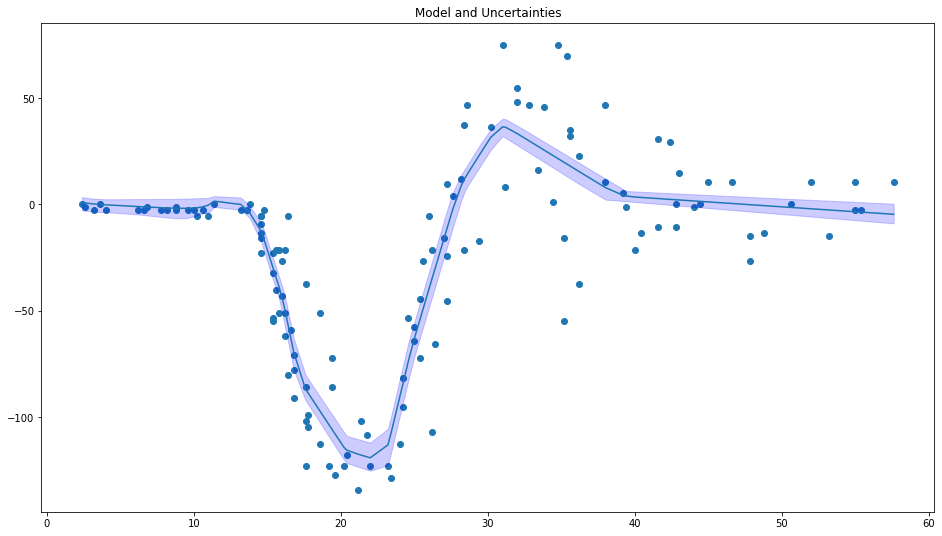

In [48]:
mu = np.mean(prediction, axis = 1)
sigma = np.std(prediction, axis = 1)
max_ = np.max(prediction, axis = 1)
min_ = np.min(prediction, axis = 1)

print(mu.shape, sigma.shape)

fig, ax = plt.subplots(figsize=(16,9))
ax.scatter(x, y)
ax.plot(x, mu)
ax.fill_between(x.squeeze(), (min_), (max_), color='b', alpha=0.2)
ax.set_title('Model and Uncertainties')
plt.show()